# An Introduction to Bayesian Optimization with Emukit

## Overview

In [1]:
### General imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors

### --- Figure config
LEGEND_SIZE = 15

### Navigation

1. [What is Bayesian optimization?](#1.-What-is-Bayesian-optimization?)

2. [The ingredients of Bayesian optimization](#2.-The-ingredients-of-Bayesian-optimization)

3. [Emukit's Bayesian optimization interface](#3.-Emukit's-Bayesian-optimization-interface)

4. [References](#4.-References)

## 1. What is Bayesian optimization?

Given a function $f: \mathbb{X} \rightarrow \mathbb{R}$ which is defined in some constrained input space $\mathbb{X}$, Bayesian optimization (BO) [[Shahriari et al, 2016]](#4.-References) tries to find the global minimum $x_{\star} \in \mathbb{X}$ of the function $f$ by solving the global optimization problem :

$$ x_{\star} =  \operatorname*{arg\:min}_{x \in \mathbb{X}} f(x). $$

Typically these objective functions $f$ are noisy, i.e $y(x) = f(x) + \epsilon$ with $\epsilon \sim N(0, \sigma_{noise})$ and expensive to evaluate. Additionally we assume that no gradient information is available and hence we treat $f$ as a black-box. 
Popular examples for such black-box optimization problems are:

 - optimizing the hyperparameters of a machine learning algorithms such as for instance a neural network, where each function evaluation requires to train and validate the neural network 
 
 - optimizing the parameters of a controller for a robot
 
 - etc.

There are two crucial bits in Bayesian optimization:

   - A prior probability measure $p(f)$ which captures our prior beliefs on $f$, called the model. Everytime we observe new data $D$ the prior will be updated to a 'posterior' $p(f|D)$ using the available data.

   - An acquisition function $a: \mathbb{X} \rightarrow \mathbb{R}$ which for each point in the input space quantifies the utility of evaluating this point. The central idea of the acquisition function is to trade off the exploration in regions of the input space where the model is still uncertain and the exploitation of the model's confidence about the good regions of the input space.

Given these ingredients, BO essentially iterates the following three steps until it achieves a predfined stopping criteria: 
1. fit the model $p(f|D_{n})$ on the currently available data $D_{n}$.
2. find the most interesting point to evaluate by $x_{n+1} \in  \operatorname*{arg\:max}_{x \in \mathbb{X}} a(x)$
3. evaluate the objective function at $x_{n+1}$, obtain $y_{n+1}$ and add the new observation to the data $D_{n+1} \leftarrow D_{n} \cup \{x_{n+1}, y_{n+1}\}$ 


## 2. The ingredients of Bayesian optimization

<h4 id='bo_intro_objective'>The Objective Function and the Input Space</h4>

As an example let's assume we want to optimize the one-dimensional forrester function: 

$$
(6x - 2)^2\sin(12x - 4)
$$

which is defined over the interval $x \in [0, 1]$.

Conviently, this function is already implemented in Emukit. Note that in order to pass it to other Emukit modules we wrap the function by the UserFunctionWrapper interface.

In [2]:
from emukit.bayesian_optimization.test_functions import Forrester
from emukit.core.loop.user_function import UserFunctionWrapper
from emukit.core import ContinuousParameter, ParameterSpace

target_function = Forrester().f
emukit_target = UserFunctionWrapper(target_function)

After defining the function, we have to define the input space $X = [0, 1]$, which in this case is purely continuous and only one dimensional. In a later section we will see how we can also apply Bayesian optimization in other domains that contain discrete or categorical parameters.

In [3]:
space = ParameterSpace([ContinuousParameter('x1', 0, 1)])

Of course in reality, evaluating $f$ on a grid wouldn't be possible, but since the forrester function is a synthetic function we can evaluate it here for visualization purposes.

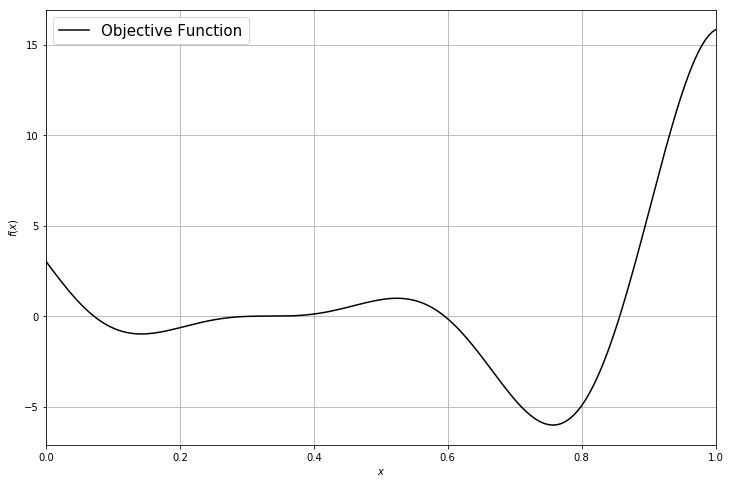

In [4]:
x_plot = np.linspace(space.parameters[0].min, space.parameters[0].max, 200)[:, None]
y_plot = target_function(x_plot)

plt.figure(figsize=(12, 8))
plt.plot(x_plot, y_plot, "k", label="Objective Function")
plt.legend(loc=2, prop={'size': LEGEND_SIZE})
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.grid(True)
plt.xlim(0, 1)
plt.show()

<h4 id='bo_intro_init_design'> The Intial Design </h4>

Usually, before we start the actual BO loop we need to gather a few observations such that we can fit the model. This is called the initial design and common strategies are either a predefined grid or sampling points uniformly at random. 

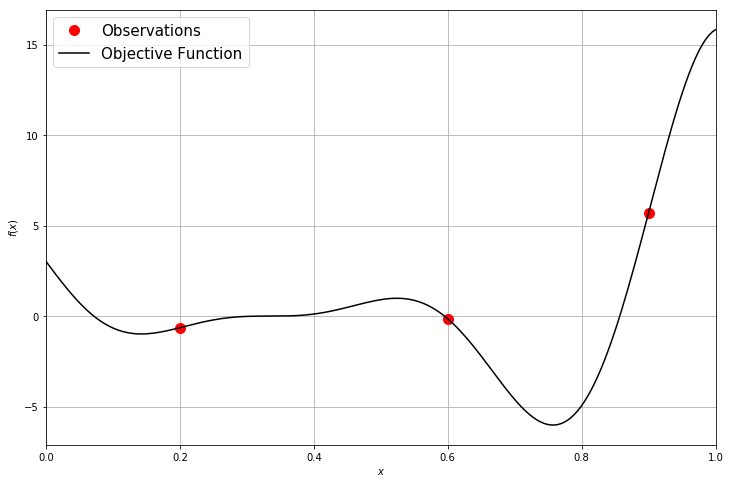

In [5]:
X_init = np.array([[0.2],[0.6], [0.9]])
Y_init = target_function(X_init)

plt.figure(figsize=(12, 8))
plt.plot(X_init, Y_init, "ro", markersize=10, label="Observations")
plt.plot(x_plot, y_plot, "k", label="Objective Function")
plt.legend(loc=2, prop={'size': LEGEND_SIZE})
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.grid(True)
plt.xlim(0, 1)
plt.show()

<h4 id='bo_intro_model'> The Model </h4>
        

Now we can start with the BO loop by first fitting a model on the collected data. 
The arguably most popular model for BO is a Gaussian process (GP) which defines a probability distribution across classes of functions, typically smooth, such that each linear finite-dimensional restriction is multivariate Gaussian [(Rasmussen and Williams, 2006)](#4.-References). GPs are fully parametrized by a mean $\mu(x)$ and a covariance function $k(x,x')$.  Without loss of generality $\mu(x)$ is assumed to be zero. The covariance function $k(x,x')$ characterizes the smoothness and other properties of $f$. It is known that the kernel of the process and has to be continuous, symmetric and positive definite. A widely used kernel is the squared exponential or RBF kernel: $$ k(x,x') = \theta_0 \cdot \exp{ \left(-\frac{\|x-x'\|^2}{\theta_1}\right)} $$ where $\theta_0$ and and $\theta_1$ are hyperparameters.
To denote that $f$ is a sample from a GP with mean $\mu$ and covariance $k$ we write
$$f(x) \sim \mathcal{GP}(\mu(x),k(x,x')).$$ 

For regression tasks, the most important feature of GPs is that process priors are conjugate to the likelihood from finitely many observations $y = (y_1,\dots,y_n)^T$ and $X =\{x_1,...,x_n\}$, $x_i\in \mathcal{X}$ of the form $y_i = f(x_i) + \epsilon_i$ where $\epsilon_i \sim \mathcal{N} (0,\sigma_{noise})$ and we estimate $\sigma_{noise}$ by an additional hyperparameter $\theta_2$.
We obtain the Gaussian posterior $f(x^*)|X, y, \theta \sim \mathcal{N}(\mu(x^*),\sigma^2(x^*))$, where $\mu(x^*)$ and $\sigma^2(x^*)$ have a close form. See [(Rasmussen and Williams, 2006)](#4.-References) for more details.

Note that Gaussian process are also characterized by hyperparameters $\theta = \{\theta_0, ... \theta_k\}$ such as for instance the kernel lengthscales. For simplicitly we keep these hyperparameters fixed here. However, we usually either optimize or sample these hyperparameters using the marginal loglikelihood of the GP. Of course we could also use any other model that returns a mean $\mu(x)$ and variance $\sigma^2(x)$ on an arbitrary input points $x$ such as Bayesian neural networks or random forests.

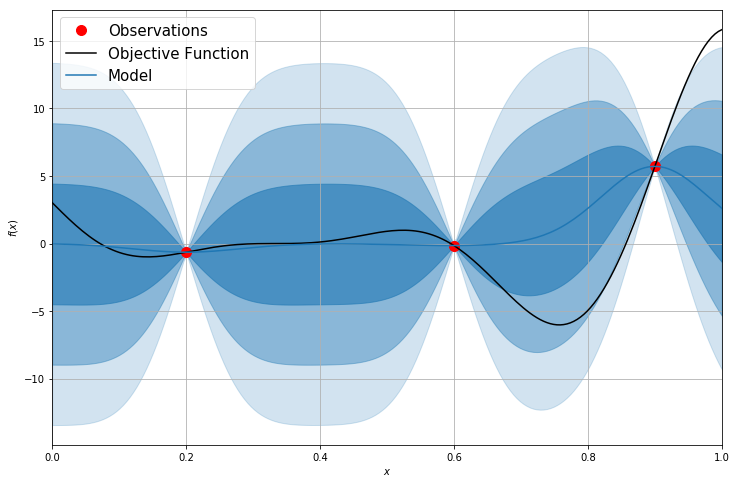

In [6]:
import GPy
from emukit.model_wrappers.gpy_model_wrappers import GPyModelWrapper

gpy_model = GPy.models.GPRegression(X_init, Y_init, GPy.kern.RBF(1, lengthscale=0.08, variance=20), noise_var=1e-10)
emukit_model = GPyModelWrapper(gpy_model)

mu_plot, var_plot = emukit_model.predict(x_plot)

plt.figure(figsize=(12, 8))
plt.plot(X_init, Y_init, "ro", markersize=10, label="Observations")
plt.plot(x_plot, y_plot, "k", label="Objective Function")
plt.plot(x_plot, mu_plot, "C0", label="Model")
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - np.sqrt(var_plot)[:, 0], color="C0", alpha=0.6)
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 2 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 2 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.4)
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 3 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 3 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.2)
plt.legend(loc=2, prop={'size': LEGEND_SIZE})
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.grid(True)
plt.xlim(0, 1)
plt.show()

<h4 id='bo_intro_acquisition'> The Acqusition Function </h4>

In the second step of our BO loop we use our model to compute the acquisition function. Various different acquisition functions exist such as :


**Probability of Improvement (PI)**: Given the currently best observed value $y_{\star} \in  \operatorname*{arg\:min} \{y_0, \ldots, y_n\}$, PI simply maximizes 

$$
a_{PI}(x) = \Phi(\gamma(x))
$$ 

where $\gamma(x) = \frac{y_{\star} - \mu(x)}{\sigma(x)}$ and $\Phi$ is the CDF of a standard normal distribution [[Jones et al., 1998]](#4.-References).



**Negative Lower Confidence Bound (NLCB)**: This acquisition function is based on the famous upper confidence bound bandit strategy [[Srinivas et al., 2009]](#4.-References). It maximized the function:

$$
a_{LCB} = - (\mu(x) - \beta \sigma(x))
$$

where $\beta$ is a user-defined hyperparameter that controls exploitation / exploration.



**Expected Improvement (EI)**: Probably the most often used acquisition function is expected improvement [[Jones et al., 1998]](#4.-References), which computes:

$$
E_{p(f|D)}[\max(y_{\star} - f(x), 0)].
$$

where $y_{\star} \in \operatorname*{arg\:min} \{y_0, \ldots, y_n\}$. Assuming $p(f|D)$ to be a Gaussian, we can compute EI in closed form by: 

$$
\sigma(x)(\gamma(x)\Phi(\gamma(x))) + \phi(\gamma(x))
$$

here $\gamma(x) = \frac{y_{\star} - \mu(x)}{\sigma(x)}$ and $\Phi$ is the CDF and $\phi$ is the PDF of a standard normal distribution.


All of these acquisition function only rely on the model and hence are cheap to evaluate. Furthermore we can easily compute the gradients and use a simple gradient optimization method to find $x_{n+1} \in \operatorname*{arg\:max}_{x \in \mathbb{X}} a(x)$.

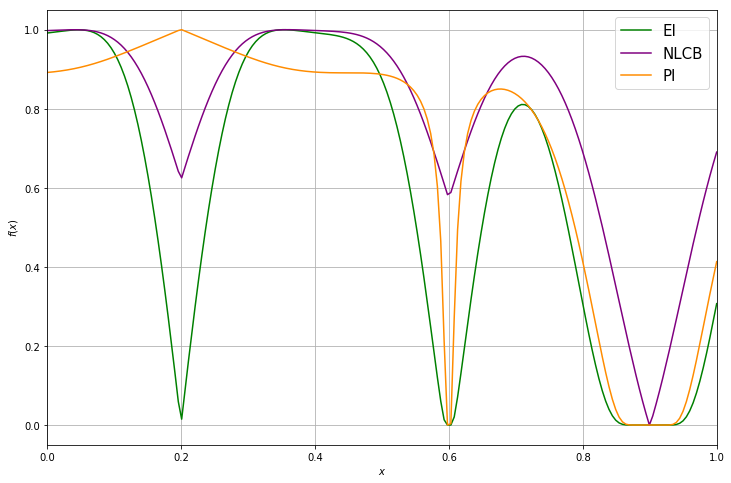

In [7]:
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement, NegativeLowerConfidenceBound, ProbabilityOfImprovement

ei_acquisition = ExpectedImprovement(emukit_model)
nlcb_acquisition = NegativeLowerConfidenceBound(emukit_model)
pi_acquisition = ProbabilityOfImprovement(emukit_model)

ei_plot = ei_acquisition.evaluate(x_plot)
nlcb_plot = nlcb_acquisition.evaluate(x_plot)
pi_plot = pi_acquisition.evaluate(x_plot)

plt.figure(figsize=(12, 8))
plt.plot(x_plot, (ei_plot - np.min(ei_plot)) / (np.max(ei_plot) - np.min(ei_plot)), "green", label="EI")
plt.plot(x_plot, (nlcb_plot - np.min(nlcb_plot)) / (np.max(nlcb_plot) - np.min(nlcb_plot)), "purple", label="NLCB")
plt.plot(x_plot, (pi_plot - np.min(pi_plot)) / (np.max(pi_plot) - np.min(pi_plot)), "darkorange", label="PI")

plt.legend(loc=1, prop={'size': LEGEND_SIZE})
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.grid(True)
plt.xlim(0, 1)
plt.show()

<h4 id='bo_intro_eval'> Evaluating the objective function </h4>

To find the next point to evaluate we optimize the acquisition function using a standard gradient descent optimizer.

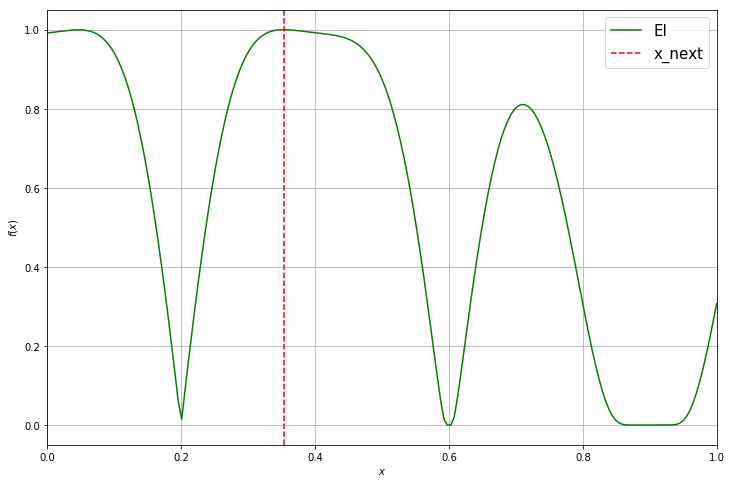

In [8]:
from emukit.core.optimization import AcquisitionOptimizer

optimizer = AcquisitionOptimizer(space)
x_new, _ = optimizer.optimize(ei_acquisition)

plt.figure(figsize=(12, 8))
plt.plot(x_plot, (ei_plot - np.min(ei_plot)) / (np.max(ei_plot) - np.min(ei_plot)), "green", label="EI")
plt.axvline(x_new, color="red", label="x_next", linestyle="--")
plt.legend(loc=1, prop={'size': LEGEND_SIZE})
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.grid(True)
plt.xlim(0, 1)
plt.show()

Afterwards we evaluate the true objective function and append it to our initial observations.

In [9]:
y_new = target_function(x_new)

In [10]:
X = np.append(X_init, x_new, axis=0)
Y = np.append(Y_init, y_new, axis=0)

After updating the model, you can see that the uncertainty about the true objective function in this region decreases and our model becomes more certain.

In [11]:
emukit_model.update_data(X, Y)

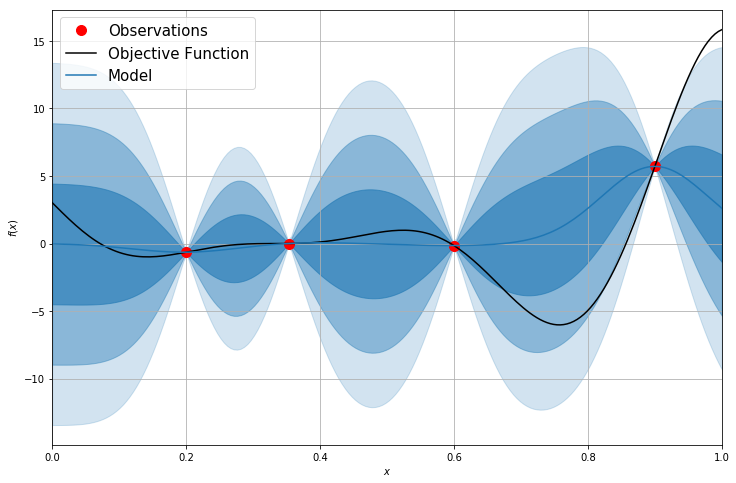

In [12]:
mu_plot, var_plot = emukit_model.predict(x_plot)

plt.figure(figsize=(12, 8))
plt.plot(emukit_model.X, emukit_model.Y, "ro", markersize=10, label="Observations")
plt.plot(x_plot, y_plot, "k", label="Objective Function")
plt.plot(x_plot, mu_plot, "C0", label="Model")
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - np.sqrt(var_plot)[:, 0], color="C0", alpha=0.6)
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 2 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 2 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.4)
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 3 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 3 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.2)
plt.legend(loc=2, prop={'size': LEGEND_SIZE})
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.grid(True)
plt.xlim(0, 1)
plt.show()

## 3. Emukit's Bayesian optimization interface

Of course in practice we don't want to implement all of these steps our self. Emukit provides a convenient and flexible interface to apply Bayesian optimization. Below we can see how to run Bayesian optimization on the exact same function for 10 iterations.

In [13]:
from emukit.examples import GPBayesianOptimization


bo = GPBayesianOptimization(variables_list=[ContinuousParameter('x1', 0, 1)],
                                         X=X_init, Y=Y_init)
bo.run_optimization(emukit_target, 10)

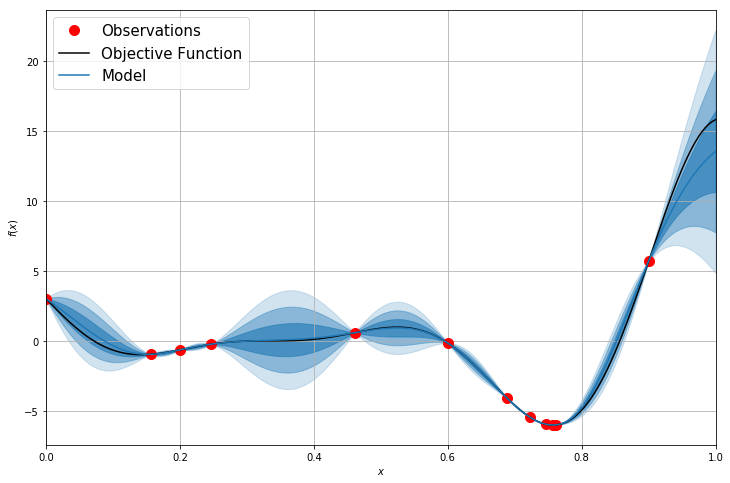

In [14]:
mu_plot, var_plot = bo.model.predict(x_plot)

plt.figure(figsize=(12, 8))
plt.plot(bo.loop_state.X, bo.loop_state.Y, "ro", markersize=10, label="Observations")
plt.plot(x_plot, y_plot, "k", label="Objective Function")
plt.plot(x_plot, mu_plot, "C0", label="Model")
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - np.sqrt(var_plot)[:, 0], color="C0", alpha=0.6)

plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 2 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 2 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.4)

plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 3 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 3 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.2)
plt.legend(loc=2, prop={'size': LEGEND_SIZE})
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.grid(True)
plt.xlim(0, 1)

plt.show()

## 4. References

- Shahriari, B., Swersky, K., Wang, Z., Adams, R. P,  de Freitas, N., 2016. *Taking the Human Out of the Loop: A Review of Bayesian Optimization.* Proceedings of the IEEE, Vol.104, No.1, January 2016

- Rasmussen, C. E. and Williams, C. K. I., 2005. *Gaussian Processes for Machine Learning (Adaptive Computation and Machine Learning.* The MIT Press, 2005

- Srinivas, N., Krause, A., Kakade, S., Seeger, M., 2009. *Gaussian Process Optimization in the Bandit Setting: No Regret and Experimental Design.* In Proceedings of the 27th International Conference  on  Machine  Learning

- Jones, D. R., Schonlau, M., Welch, W. J., 1998. *Efficient Global Optimization of Expensive Black-Box Functions.* Journal of Global Optimization, 1998